#Reading data

In [ ]:
import pandas as pd

df=pd.read_csv(
    'https://raw.githubusercontent.com/nbertagnolli/counsel-chat/master/data/20200325_counsel_chat.csv',
    delimiter=','
)
df.head()

Unnamed: 0  questionID  ... views  split
0           0           0  ...  2899  train
1           1           0  ...  3514  train
2           2           0  ...     5  train
3           3           0  ...    31  train
4           4           0  ...   620  train

[5 rows x 12 columns]

# Preprocessing & Loading into a dataframe

In [ ]:
# filtering dataframe 
# selectiong topics 
topic_list= ['depression' ,'relationships'	,'intimacy'	,'anxiety'  ,'family-conflict'  ,	'parenting' , 	'self-esteem']  
filtered_df= df[df.topic.isin(topic_list)]
len(filtered_df)

1302

In [ ]:
filtered_df.loc[filtered_df['questionID']== 1]['upvotes']

23    2
24    1
25    1
26    1
27    1
28    1
29    0
30    0
31    0
32    0
33    0
34    0
35    0
36    0
37    0
38    0
39    0
40    0
41    0
42    0
43    0
44    0
45    0
46    0
47    0
48    0
49    0
50    0
51    0
52    0
53    0
54    0
55    0
56    0
57    0
58    0
59    0
60    0
61    0
62    0
63    0
64    0
65    0
66    0
67    0
68    0
69    0
Name: upvotes, dtype: int64

In [ ]:
# sorting
filtered_df=filtered_df.sort_values(by=['upvotes'], ascending=False)
# remove duplicated questions 
filtered_df=filtered_df.drop_duplicates(subset='questionText', keep="first")
len(filtered_df)

575

In [ ]:
# dividing by topic

grouped = filtered_df.groupby('topic')
depression = grouped.get_group("depression")
depression['topic'].value_counts()

# dividing by topic

relationships = grouped.get_group("relationships")


intimacy = grouped.get_group("intimacy")


anxiety = grouped.get_group("anxiety")


family_conflict= grouped.get_group("family-conflict")

parenting = grouped.get_group("parenting")


self_esteem = grouped.get_group("self-esteem")

len(depression)

132

In [ ]:
# spliting the dataframe into batches 
import numpy as np 
df_split = np.array_split(depression,70)
df_split_filtered=[]
for dataframe in df_split:
    if (len(dataframe))>=2:
      df_split_filtered.append(dataframe)
for dataframe in df_split_filtered:
    print(len(dataframe))

2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2


In [ ]:
texts=[]

for dataframe in df_split_filtered:

  text=""
  for index, row in dataframe.iterrows():
      text= text + " "+ row['answerText']
  texts.append(text)

len(texts)

62

In [ ]:
text_len=[]
for text in texts:
  text_len.append(len(text))
print(max(text_len))

4256


# Question Answering

In [ ]:
!pip install numpy scipy librosa unidecode inflect librosa transformers

     |████████████████████████████████| 235 kB 26.3 MB/s 
     |████████████████████████████████| 2.9 MB 29.1 MB/s 
     |████████████████████████████████| 56 kB 2.8 MB/s 
     |████████████████████████████████| 636 kB 44.3 MB/s 
     |████████████████████████████████| 3.3 MB 52.0 MB/s 
     |████████████████████████████████| 895 kB 52.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


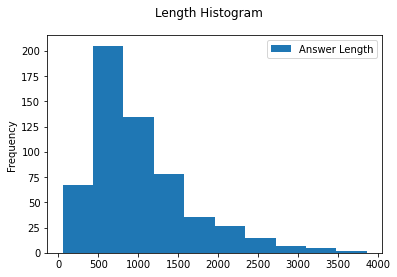

In [ ]:
# length of answers
length=filtered_df['answerText'].str.len()
length=pd.DataFrame(length).rename(columns={'answerText': 'Answer Length'})
plot=pd.DataFrame(length).plot(kind='hist',title="Length Histogram",subplots=True)
figure=plot[0].get_figure()
figure.savefig('Answer_length_histogram')

# Question Answering

In [ ]:
import torch
from transformers import DistilBertForQuestionAnswering
model = DistilBertForQuestionAnswering.from_pretrained('distilbert-base-uncased-distilled-squad')

from transformers import DistilBertTokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased-distilled-squad')

Downloading:   0%|          | 0.00/451 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/253M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

In [ ]:
import torch

In [ ]:
def answer_question(question, answer_text):
    '''
    Takes a `question` string and an `answer_text` string (which contains the
    answer), and identifies the words within the `answer_text` that are the
    answer. Prints them out.
    '''
    # ======== Tokenize ========
    # Apply the tokenizer to the input text, treating them as a text-pair.
    inputs = tokenizer(question, answer_text,truncation=True, return_tensors='pt')
    input_ids = tokenizer.encode(question, answer_text)
   

    start_positions = torch.tensor([1])
    end_positions = torch.tensor([3])
    

    # Report how long the input sequence is.
    print('Query1 has {:,} tokens.\n'.format(len(inputs)))
    print('Query has {:,} tokens.\n'.format(len(input_ids)))

    # ======== Evaluate ========
    # Run our example question through the model.
    outputs = model(**inputs, start_positions=start_positions, end_positions=end_positions)

    start_scores = outputs.start_logits
    end_scores = outputs.end_logits
                                    # token_type_ids=torch.tensor([segment_ids])) # The segment IDs to differentiate question from answer_text

    # ======== Reconstruct Answer ========
    # Find the tokens with the highest `start` and `end` scores.
    answer_start = torch.argmax(start_scores)
    answer_end = torch.argmax(end_scores)

    # Get the string versions of the input tokens.
    tokens = tokenizer.convert_ids_to_tokens(input_ids)

    # Start with the first token.
    answer = tokens[answer_start]
   
    # Select the remaining answer tokens and join them with whitespace.
    for i in range(answer_start + 1, answer_end + 1):
        
        # If it's a subword token, then recombine it with the previous token.
        if tokens[i][0:2] == '##':
            answer += tokens[i][2:]
        
        # Otherwise, add a space then the token.
        else:
            answer += ' ' + tokens[i]

    #print('Predicted Answer: "' + answer + '"')
    return answer

In [ ]:
len(df_split_filtered)

62

In [ ]:
# try on one sample
j=0
count = 0 
for i in range (0, len(df_split_filtered)):
  for index,row in df_split_filtered[i].iterrows():
    print ('Predicted answer: ',answer_question(row['questionTitle'],texts[j] ))
    print('Real Answer: ',row['answerText'])
    if (answer_question(row['questionTitle'],texts[j]) in row['answerText']):
       count =count+1
  j=j+1

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Query1 has 2 tokens.

Query has 584 tokens.



Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Predicted answer:  depression . if you feel sad on most days , it is worthwhile speaking to a psychologist to determine whether you suffer clinical depression . feeling sadness is a normal response to loss , whether you lose a family , friend , job , or something you deem important in your life . however , feeling sadness all the time is a signal that you are not happy about something in your life
Real Answer:  Hello,While one can be sad from time to time, feeling sad "all the time" could be a sign of depression. If you feel sad on most days, it is worthwhile speaking to a psychologist to determine whether you suffer clinical depression. Feeling sadness is a normal response to loss, whether you lose a family, friend, job, or something you deem important in your life. However, feeling sadness all the time is a signal that you are not happy about something in your life. If it is related to your family and often relationship with family members could affect our self-esteem and self-worth,

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Query1 has 2 tokens.

Query has 596 tokens.



Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Predicted answer:  [CLS]
Real Answer:  Frequently when working with clients, I utilize the A-B-C model developed by Albert Ellis, the founder of Rational Emotive Behavior Theory. The theory basically states that you can not control an event but you can control your reaction to the emotions associated with said event. For instance here is an example:A (Action or Event): You need to talk to someone and that person is not calling you back.B (Behavior or Response): You begin to tell yourself that this person is too busy for me or I am not important to this person.C (Consequence): You feel depressed.If you look at the model, B has a direct effect on C. The thought is if you change your reaction to A, then C will have a better consequence, such as:A: stays the same.B (this is what you change): This person must be busy, they will call me back when they get a chance or I can call someone else to lean on for support until this person is available.C: Decreased feelings of depression & overall fu

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Query1 has 2 tokens.

Query has 519 tokens.



Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Predicted answer:  [CLS]
Real Answer:  Wow that is tough. There is nothing worse than fearing abandonment when you are already struggling with depression. It sounds like you are still wanting to work through whatever challenges you and your husband are having but your husband may not be on the same page. I would encourage you and your husband to seek professional support if you haven't already. While depression can put real strains on a relationship, relationship problems can lead to or contribute to depression and there may be some real benefits to both of you in doing some couple therapy. With that being said - if your husband is not willing to do therapy or is clear that he wants the relationship to end, then I can't see what choice you have but to "respect his decision" as you mentioned. This doesn't mean that you have to feel okay with the decision - as I'm sure you wouldn't - but ultimately loving one another and staying in committed relationships is a choice that we each have to

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Query1 has 2 tokens.

Query has 520 tokens.



Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Predicted answer:  help oneself feel better
Real Answer:  In a way, self-harm can present somewhat like an addiction.  According to new research within the field of neuroscience there is a valid explanation for this.  When a person cuts or uses other forms of self harm, the body produces endorphins to help make a person feel better.  If a person was dealing with depression or high anxiety, that might be misinterpreted by the brain as a way to help oneself feel better and a new neural network or map might form (addiction) that would utilize this new behavior.  Another way to look at it would be thru a behavioral lens, a positive reward for a behavior, even though the behavior has other long term negative consequences.  Consider working with someone who can both have you work on and address those items that trigger your behavior and the root causes, in this case sadness or depression, and second find someone who can help give you alternatives that take into account the neurological requi

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Query1 has 2 tokens.

Query has 652 tokens.



Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Predicted answer:  [CLS]
Real Answer:  You're probably not going to like my answer.Your question says a lot about what YOU want rather than what she wants or what may be best for her. Sometimes, what's best for a person is the hardest thing to do, and may be completely opposite of what YOU want.Addictions don't happen in a vacuum. If you've had any experience with addicts at all, then I'm sure you've heard the term "enabler". A lot of the times, when people think they're "helping", they're actually enabling the addict to continue their self-destructive behavior. Tough love and clear boundaries are needed in a lot of situations, but especially with addictions. Family and friends are often the biggest contributing factor to someone choosing to use/drink, continuing to do so, or relapsing back into it.You said she recently quit. You said she is depressed. She wants to move. When a person receives counseling for addictions, they are encouraged to make changes like this. They need to break 

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Query1 has 2 tokens.

Query has 652 tokens.



Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Predicted answer:  [CLS]
Real Answer:  It sounds like you are noticing that you are drawn towards sad and negative content and it's hard to understand why. This may sound counter-intuitive, but sometimes we do things that on the surface may look problematic (or even cause us some real problems) because it serves us in some unseen way. A simple example would be somebody who is addicted to a substance; their addiction may be causing serious problems in their life, and they may even know it, but the addiction serves them by helping them to avoid painful feelings that they anticipate having if they quit using. Now I am not saying that what you describe is an addiction, it is just a really illustrative example of the unseen benefit.One thing I would be wondering about is what is the unseen benefit of seeking out sad and negative content? I'd also be wondering what your relationship is to other feelings. These are things you may benefit from exploring with a competent therapist.
Query1 has 2

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Query1 has 2 tokens.

Query has 585 tokens.



Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Predicted answer:  [CLS]
Real Answer:  Seasonal Affective Disorder (S.A.D.) is a term that reflects how many people are affected by the changing seasons, especially fall to winter.  Everyone suffers with some form of this (lessened activity levels, increased isolation, etc.) while some find that this time of year can put them into a deeper depression. If you have noticed that this happens frequently, there are some ways you can definitely help yourself going forward:1. Attend therapy to learn strategies and tools to help you to manage your mood.  It's important to stay within the therapy until you feel you have mastered these tools. 2. Push yourself to interact more with your social groups and other positive activities. It's easy to go out and spend the day outside in the summer months, when the temperature is warm and the sun shines for long periods of the day, but it seems harder to find fun ways to spend your time when the temperature drops and darkness comes on so quickly.  Perhaps

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Query1 has 2 tokens.

Query has 591 tokens.



Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Predicted answer:  your parents are being unsupportive
Real Answer:  Hi Georgia, There's a really good lesson here. People tell us things, and we tend to think that's the truth...but it's not! I'll do some translating for you..."You're so ungrateful" means "I need you to be successful and happy in order for me to feel I'm a good parent"."You're too young to be depressed" means "I don't want to deal with your mental health issues right now. I'll pretend it's not happening so I don't have to face my fear and shame"."It's only going to get worse" just means "I don't know how to support you beyond scaring you into wanting to at least fake happiness for my sake".Your parents are being unsupportive, not because you're not suffering, but because this is all they're capable of right now. They are not where you will find the support you need, so keep looking for it in other places. It's out there. If might be an aunt or a friend, or a friend's aunt. It might be a therapist or a bus driver or yo

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Query1 has 2 tokens.

Query has 856 tokens.



Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Predicted answer:  working with a competent therapist
Real Answer:  It's sounds like you are feeling pretty overwhelmed with intrusive thoughts and are feeling very criticized by others as well. I think it is great that you are reaching out and I can tell that you want this to change. Working with a competent therapist may be a good option for getting some more clarity about what is going on, developing ways to cope, and eventually getting relief from these overwhelming experiences.
Query1 has 2 tokens.

Query has 856 tokens.



Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Query1 has 2 tokens.

Query has 861 tokens.



Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Predicted answer:  [CLS]
Real Answer:  Hi Boise, I'm sorry that you've lost this love. The fact that you were planning marriage and a future tells me that you meant something very special to each other at that time. It's different now...you're not together anymore, but you can't accept this, right? Good for you for identifying that this situation is damaging your life. You've been grieving for longer than you were together. Oh, but really you've not been grieving...you're stuck still loving her instead of moving forward. Unrequited love is a recipe for eternal heartache. Let's look at some possible blocks to moving forward.It could be that there's something unfinished for you. Maybe you felt hurt and you didn't have the chance to say so, or you felt you hurt her and you didn't have the chance to make it right. Maybe there's a burning question you need to ask or something else you need to say. Maybe you want to tell her you've never stopped loving her, and see if she feels the same way.

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Query1 has 2 tokens.

Query has 623 tokens.



Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Predicted answer:  [CLS]
Real Answer:  Since you realize that hearing voices in your head is not usual for you, then definitely there is a problematic situation happening within your awareness of who you are.if you recently started taking a new drug or increased dosage of one you already were taking, and the voices started shortly after, then yes, it is possible medication created your problem.Start by telling whoever gave you the presecription, about the problem you're having."Crazy" has some flexibility as to whether someone is this way or not.Certainly a very positive sign that you're not crazy, is that you're self-aware of a problem within yourself. And, you're responsible toward yourself and making effort to address this problem.Crazy people usually don't do responsible behaviors.
Query1 has 2 tokens.

Query has 623 tokens.



Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Query1 has 2 tokens.

Query has 630 tokens.



Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Predicted answer:  [CLS]
Real Answer:  I really love that you're taking responsibility for your pessimism here. There's a modern parable about two young brothers. One child is in a room full of every toy you could imagine, and he's miserable; the other is in a room full of horse manure, and he's flinging it around with joy. So then someone comes and asks the first boy why he's so miserable, because he has so much. He says that he's missing the one toy that he really wants. Then the brother is asked why he's so happy in a room full of manure, and he says "With all this sh-t, there's gotta be a pony in here somewhere!"Happiness is a state of mind, and I hear you saying that you used to be happy, so maybe this means you believe it's possible. That's a wonderful start.Research on depression shows us that it is very linked to pessimism. You say "I always see the worst end of things". That's pessimism. Life is like an elephant. If all you see is roughness, backup and walk around; the view wi

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Query1 has 2 tokens.

Query has 705 tokens.



Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Predicted answer:  if your husband has an established therapist
Real Answer:  Hello, and thank you for your question. This is a very serious time. I don't mean to frighten you, but you are right to be concerned. The time right after people leave the hospital after receiving psychiatric services is a time of high risk for suicide. It is very important, after hospitalization, to get follow-up care with a professional as soon as possible. If your husband has an established therapist, this is the time to call. It is also a good time to alert your support system of friends, family, clergy or others to let them know he is still struggling. This is good support for him AND you.It is important to think about means and opportunity to make another attempt. Means really do matter.  So, if you have a firearm in the home, it is really important to remove it. You can't remove all things that a person may hurt themselves with, but some things are more lethal than others. Firearms are very lethal. I a

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Query1 has 2 tokens.

Query has 702 tokens.



Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Predicted answer:  [CLS]
Real Answer:  Philadelphia, there is help out there. For your daughter's sake, start somewhere. Feelings are only that; your worst fears about who you are are only based on a few moments that haven't gone well. Depression is so treatable, but you have to seek treatment from a professional.Here's a quick exercise for you to do that can show you how therapy might work... fear is telling you the worst possible story of your life, right? So... if there was an opposite story...the very best story that someone could tell about you and your life...what would that be? Who would be telling it? Someone who loves you? Someone who was around you when you were that outgoing person? Someone who's been watching your life from the start? God? Write that best story. I dare you to give it as much credibility as the worst one. Therapy is often about helping people reject their "worst stories". I invite you to start exploring with a qualified therapist whatever barriers stand betw

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Query1 has 2 tokens.

Query has 894 tokens.



Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Predicted answer:  most
Real Answer:  Let me start by saying there are never too many concerns that you can bring into counselling. In fact, most people who come to see me for counselling have more than one issue they would like to work on in psychotherapy and most times these are all interconnected. In counselling, we work together, collaboratively, to figure out which issues you would like to address first and then together we develop an individualized plan of care. Basically, it’s like a road map of where you want to go, how are you going to get there, looking at stopovers, some scenic routes others possibly not so scenic, however, necessary. Of course, these plans can also change due to internal (what we have control over like our thoughts, feelings and behaviours) or external reasons (those things that are outside our control). I would encourage you to take the next step and reach out to a professional you can trust and build rapport with by co-journeying through whatever concerns

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Query1 has 2 tokens.

Query has 897 tokens.



Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Predicted answer:  a combination of appropriate medication
Real Answer:  The best way to handle depression and anxiety is with a combination of appropriate medication given to you by a medical doctor, and therapy to help you understand the thoughts, feelings, and behaviors that are causing the depression and anxiety in the first place and then to replace these with more positive thoughts and behaviors. This is not something that anyone should just “white knuckle” and try to get through on their own with no help. Cognitive Behavioral Therapy is a technique that has been proven helpful for depression and anxiety. This takes a therapist trained in CBT. There are some things in life that you cannot change and must learn to accept. A lot of people spend time trying to change things that they have no control over. This may be the behavior of someone else in your life or it could be a situation that you cannot change, such as the recent death of a loved one, a lost relationship, or an acciden

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Query1 has 2 tokens.

Query has 652 tokens.



Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Predicted answer:  [CLS]
Real Answer:  It sounds like you have been a positive support for your fiancee. There is no doubt that this situation is a great challenge for the both of you. While it may feel like you are responsible for her health and happiness, it is important that you understand that you, on your own, won't be able to resolve her mental health issues. Based on what you have explained, it sounds like she needs to get a medical and/or psychiatric evaluation. Whether or not she decides to take medication is her (and your) decision, but keeping an open mind about treatment options is important. I suggest that she see a therapist on her own in order to better understand and cope with her anxiety and depression, especially given her suicidal thoughts. You would also likely benefit from therapy, individual or couple's therapy, in order to address how you are feeling and best learn how to support her and your relationship. I wish the very best for both of you and hope that things

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Query1 has 2 tokens.

Query has 655 tokens.



Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Predicted answer:  feelings of worthlessness is unfortunately common
Real Answer:  Hello, and thank you for your question and seeking advice on this. Feelings of worthlessness is unfortunately common. In fact, most people, if not all, have felt this to some degree at some point in their life. You are not alone. Changing our feelings is like changing our thoughts - it's hard to do. Our minds are so amazing that the minute you change your thought another one can be right there to take it's place. Without your permission, another thought can just pop in there. The new thought may feel worse than the last one! My guess is that you have tried several things to improve this on your own even before reaching out on here. People often try thinking positive thoughts, debating with their thoughts, or simply telling themselves that they need to "snap out of it" - which is also a thought that carries some self-criticism. Some people try a different approach, and there are counselors out there that 

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Query1 has 2 tokens.

Query has 537 tokens.



Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Predicted answer:  if you are medically clear in the reasons for losing your erection , then reflect on what may be creating a loss in confidence in either who you are and what you ' re doing with your life , or whether your wife has these sort of problems within herself . often a problem transfers ownership of who shows it . if you are a sensitive person its possible your erection problem reflects your wife ' s insecurities and self - doubt
Real Answer:  First step always is to do a medical rule out so that you're sure the problem is psychological and emotion based, not a medical condition which requires care and attention.If you are medically clear in the reasons for losing your erection, then reflect on what may be creating a loss in confidence in either who you are and what you're doing with your life, or whether your wife has these sort of problems within herself.Often a problem transfers ownership of who shows it.If you are a sensitive person its possible your erection problem re

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Query1 has 2 tokens.

Query has 541 tokens.



Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Predicted answer:  [CLS]
Real Answer:  You may be pressuring yourself to be the one person who fixes the relationship.  This is impossible because the relationship belongs to both of you.Has he told you whether he feels about himself that how he interacts with you, is contributing to problems in the couple?Is he willing to understand what you're asking of him, without shutting down with whatever he is feeling when he feels blamed?Your feelings of distrust are the natural outcome of not being properly heard and understood.  He's not willing to listen to you, so of course you're frustrated and this frustration comes out in all sorts of uneasy feelings.Willingness to hear each other in a non-defensive way, sometimes requires a couples therapist's assistance.Ask your husband if he's willing to understand, not judge you.  Be willing yourself to do the same.If after trying and getting nowhere, you'll know when to stop trying on your own as a couple and to find a specifically trained couples 

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Query1 has 2 tokens.

Query has 558 tokens.



Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Predicted answer:  [CLS]
Real Answer:  Are there any times or moments in which you feel other than "empty"?  Start with knowing the context of when you feel something other than empty.If there is no recent example, then in your mind, go back in time to think of when you felt something other than empty.  Recall what you liked about this time, whether you were by yourself or with others, what type of activity you were involved at the time of non-emptiness.How did you come to your conclusion that your life purpose is to reproduce and die?  If this is what your parents, siblings and extended family believe, it is possible that you have a broader view of yourself and haven't yet uncovered a way of defining your own philosophy of living.Give yourself the time to browse around online, or in person social meet ups, on your interests.  It is possible you will discover entire new areas of life and ways of considering life, that are brand new to you and which connect to your true self.This is one

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Query1 has 2 tokens.

Query has 557 tokens.



Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Predicted answer:  [CLS]
Real Answer:  Hi Tennessee, There is nothing wrong with you. There are many good reasons why you didn't say no. You didn't say no because you were caught off guard and unprepared; there is no place in life that teaches girls or boys how to manage it when someone crashes a sexual boundary. You also live in a culture where girls are encouraged to be cooperative and not upset people, and to put the needs of other people first. You instinctively want people to like you, and people can be very coercive sexually. You said it yourself; you "gave in". He wore you down.There's nothing wrong with you. It wasn't your job to say no. Women aren't the gatekeepers of male sexual urges. It was his job to get your consent first. He pressured you into it. A good therapist would help you to dig deep and uncover all these barriers to saying no and more. If you said no, what might happen then? What might that mean about you? What are you avoiding feeling? Unloved, unwanted, cold? W

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Query1 has 2 tokens.

Query has 760 tokens.



Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Predicted answer:  [CLS]
Real Answer:  Thank you for posting.  I'm interested to hear some more information; such as, if you live by yourself or family, if you go to school/employed/unemployed, and what kind of things do you like to do with friends or by yourself.  Often times, when we are experiencing a strong emotion that we interpret as negative, we put most of our focus on that negative emotion and struggle to see that we do not always feel that specific emotion.  There are typically points in the day (even if it is for only in 1 minute intervals) when we do not feel that negative emotion.  When we overgeneralize, we use words like "always" or "never" and when we use those words and it may not be totally true, we feel the negative emotion based on an inaccuracy which is not fair to you.  Ask yourself some of these questions: Am I being realistic when I'm overgeneralizing things? Have I ever noticed a short period of time that I wasn't feeling anxious?  What do I notice when I am fe

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Query1 has 2 tokens.

Query has 758 tokens.



Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Predicted answer:  [CLS]
Real Answer:  I agree; you need more care and support. No one deserves to feel alone, or like they hate themselves. We're all wonderful, imperfect, complicated people and we're at our best when we're all helping each other. I'm glad you wrote this question, because a lot of people have this feeling sometimes. I can tell that you're smart, because you seem to sense that the two things you wrote about are connected...you "not being yourself", and then how you felt when your grandma died. When Grandma died, you needed and deserved extra love and support, but the people around you didn't seem to give it to you, maybe. My hunch is that they wanted to, but that they didn't know how much you needed it, or what you needed exactly. The older you get, the more you will have to take charge of letting people know what you need. Maybe this is one of the suckier parts of being mature, but that's how it works. When you started middle school, it sounds like you changed; you go

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Query1 has 2 tokens.

Query has 562 tokens.



Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Predicted answer:  [CLS] i always feel depressed [SEP] feeling alone and / or isolated
Real Answer:  Feeling alone and/or isolated is almost always associated with being depressed. As humans, we need connection and interaction with others in order to feel satisfied. Given that you are frequently thinking about death, I highly recommend that you see a mental health professional as soon as possible to help assess your immediate needs and address any underlying issues that may be contributing to your feelings of loneliness and depression. The good news is that with proper, consistent treatment and commitment to change, things can really turn around for you. A therapist can work with you on building enjoyable activities into your daily routine, change maladaptive thought patterns that contribute to your sadness, and help with exploring what has gotten you to where you are. By learning about where your sadness originates, engaging in preferred activities, and changing your thought patterns,

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Query1 has 2 tokens.

Query has 563 tokens.



Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Predicted answer:  [CLS]
Real Answer:  Everyone has some level of anxiety - it's what helps us respond to stressors in our lives and clues us into the fact that we need to respond to something going on. However, if you're feeling overwhelmed by racing thoughts, feeling like you spend a lot of energy worrying about something specific or even pretty much anything at all, and you're starting to find that it's getting in your way when it comes to living your life the way you want, then I'd suggest seeing a counselor or therapist for an assessment for anxiety. Your other concerns, though, seem pretty "normal" for someone who is in a relationship with a partner who has children. As a married stepmother, I've been there, and as a therapist, I can tell you that the boundaries and communication skills you have in your relationships need to be healthy for you to feel healthy. Finding some support from a group of others whose partners have children might be really helpful - being able to hear fro

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Query1 has 2 tokens.

Query has 631 tokens.



Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Predicted answer:  listen to anxiety
Real Answer:  Is it possible you simply didn't mix well with the particular therapists with whom you've worked?   If this is possible, interview a therapist before  starting therapy.   Then you will be choosing a therapist who feels compatible with your way of seeing yourself and your life.Also, therapy isn't for everyone.Read about the different healing modalities and see if one of these speaks to your interest in feeling better.What matters most is finding among all the legitimate healing methods, what you believe will be effective.
Query1 has 2 tokens.

Query has 631 tokens.



Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Query1 has 2 tokens.

Query has 622 tokens.



Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Predicted answer:  [CLS]
Real Answer:  Hi Helena,I felt a bit sad when I read this. This is a new term for me... "semi-relationship". What does it mean? I know that today's culture for young people is more of a "hook-up" culture than a dating one. Maybe that means that you develop connections to people but you keep yourself from hoping for a full relationship because no one is doing that anymore. That makes me feel sad. I hear a lot of young women (I'm not sure you're female, but that's my guess) say that they struggle with hook-ups because they can't let themselves hope for a phone call after a hook-up. Research tells us that, after a hook-up, college age women tend to feel used and unworthy, and men tend to feel guilty. I think this scenario works better for men than women, but many of both genders are left unsatisfied in the end.This is only one possible explanation for your anxiety...that your gut knows that it wants to feel fully coupled with someone but you struggle with whether 

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Query1 has 2 tokens.

Query has 584 tokens.



Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Predicted answer:  [CLS]
Real Answer:  It sounds like you are feeling like things are hopeless and out of control and you're not sure what to do about it. If you can find a competent therapist to work with, together you may be able to come up with some strategies for alleviating the overwhelming distress that you are experiencing and gain some insight into what may be contributing to these challenges. Additionally, a therapist may be able to support you in getting back on your feet in regards to work, a place to live, and showing up with your partner in a way that will be more satisfying to you.
Query1 has 2 tokens.

Query has 584 tokens.



Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Query1 has 2 tokens.

Query has 585 tokens.



Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Predicted answer:  [CLS]
Real Answer:  One of the first steps is to manage anxiety and depression symptoms are to establish a good self-care routine.  Start with the most basic things: Eating balanced meals, sleeping at from 6-8 hours and exercise at least 30 minutes a day.  These will help you to regulate the chemical imbalance that affects your mood, plus exercising gives you time to vent and be distracted from your thoughts.  Once basic self-care is established, I suggest that is a good time to start exploring the source of these feelings, and address them trough therapy.  If you have difficulty initiating self-care routine talk to your therapist about what motivates you and pushes you to do things, you might find the key during the process.  You could also contact your physician or a psychiatrist to discuss medication options if it’s too challenging to begin basic self-care.¿Cómo puedo controlar mi ansiedad?Uno de los primeros pasos para manejar la ansiedad y la depresión es establ

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Query1 has 2 tokens.

Query has 789 tokens.



Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Predicted answer:  unresolved anxiety
Real Answer:  It has been said that depression is often the result of a blocked goal.  Often people struggle with both anxiety and depression but have difficulty determining which is the most important issue. For some, depression is the result of frequently blocked goals and when their predominant issues are evaluated, they discover that they are anxious (worried) about a lot of areas in their life but seem to find no relief.  When there is no relief and there have been numerous attempts (either in their mind or in practical application) to resolve the anxiety, depression is often the result.  In this type of case, depression is not the main or underlying issue. The anxiety is the underlying issue.  Having "a lot on my mind" sounds like anxiety. Unresolved anxiety can lead to feelings of depression which are often associated with "emptiness."  In the question above, I would want to evaluate all of the issues surrounding having "a lot on my mind" an

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Query1 has 2 tokens.

Query has 797 tokens.



Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Predicted answer:  you have shifted roles in your life
Real Answer:  It is not easy being a wife and mother. You have shifted roles in your life. You went from having a career to focusing on your family. Transitioning can be hard, especially when we feel we gave something up that we really wanted. I want to acknowledge you for wanting to be the best wife and mother you can. I think it is great that you are self-aware and want to work on this.Feeling "unhappy and trapped" may also mean that you are  believing these negative thoughts are absolutely true. We have lots and lots of thoughts throughout the day. Sometimes we pay a lot of attention to some and some we ignore. Right now these thoughts are getting a lot of your attention and perhaps you are thinking because you are thinking them they are true.  Is it really true that you trapped? You also said that you have an amazing life. It doesn't sound like you are only having negative thoughts. You have some positive ones, too. However, yo

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Query1 has 2 tokens.

Query has 636 tokens.



Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Predicted answer:  [CLS]
Real Answer:  If you are a people-pleaser type or a natural caretaker, you can slowly "lose yourself" over time if you are always tending to the needs of others and neglecting yourself.  If this sounds like a familiar pattern for you, this may have happened without you even realizing it if you were raised in a family where you had to pick up the slack alot.  Maybe your parents were addicts or they might have even just worked all the time and you learned to "take care of everything" because that is what you had to do to help the family run smoothly. Over time, a person who grows up in this type of environment learns that you put the needs of others before your own.  You might also be stuck in these types of patterns in intimate relationships as well; if you completely give yourself over to your significant other and you don't create a life for yourself with your own interests and supportive friends, you are at risk of losing what is unique and amazing about you.

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Query1 has 2 tokens.

Query has 647 tokens.



Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Predicted answer:  [CLS]
Real Answer:  Each person handles themselves differently in any situation.Since you are willing to speak about how you feel, keep looking for blogs and forums on whatever topics you feel most describe your current circumstance.Your mother and sister, even though they are family seem to prefer the opposite method to yours.Find your own path of supportive other people and possibly a therapist.This way you’ll have understanding and validation which your mom and sister don’t want to give you right now.
Query1 has 2 tokens.

Query has 647 tokens.

Query1 has 2 tokens.

Query has 421 tokens.

Predicted answer:  [CLS] why do i feel like i don ' t belong anywhere ? [SEP] from the little bit you wrote , my guess is you haven ' t figured out where and how to lay down your own set of roots . usually people who have a university level eduction are old enough to work in order to support themselves . unless you have a medical condition
Real Answer:  From the little bit you w

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Query1 has 2 tokens.

Query has 1,018 tokens.



Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Predicted answer:  [CLS]
Real Answer:  Maybe right now it is time for you to rest before the next wave of new activity comes along.To have "no interest" may mean you are already so saturated with recent situations and their meaning that you are naturally withdrawing in order to regain your energy.
Query1 has 2 tokens.

Query has 1,018 tokens.



Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Query1 has 2 tokens.

Query has 1,029 tokens.



Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Predicted answer:  your family
Real Answer:  I understand that talking about our feelings can be awkward and using jokes is a way to relieve that awkwardness, but there is a right or wrong way to talk about your feelings. The important part is to recognize that you need help addressing those feelings and reaching out, which you are doing already.  Having small conversations with your family is helpful, you can explain to them that you have been experiencing emotional discomfort and would like to talk to them about it.   Since you been experiencing anxiety, panic attacks, and have thought about dying,  It is VERY important that you ask them to help you make an appointment with a mental health professional.  Those symptoms indicate that your body is having a hard time managing intense feelings and it will be helpful if you understand why they occur and how to cope with them. You may contact your school counselor or you may schedule an appointment with a local therapist.  You may contact 

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Query1 has 2 tokens.

Query has 926 tokens.



Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Predicted answer:  [CLS]
Real Answer:  Feelings are real, is very unlikely that you are making them up since they are a response to the thoughts in your mind and your daily experiences and interactions. Often we assume that feeling sadness is bad and that we should only feel happiness and joy; but all feelings have a purpose: joy, sadness, anger, frustration, excitement, anxiety, among others.   Is not healthy to experience the same feeling for a long time, so we should learn to identify what causes them and how to process them so you can navigate through life experiences with more ease. I am a Licensed Professional Counselor in Texas, currently providing services in West Houston.  You may reach me at 787-466-5478 to schedule an appointment.   ------------------------------------------------------------------------------------------------------------------------------------------Me he estado sintiendo tristeCuando salgo con una persona en particular o cuando llego a casa, estoy triste 

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Query1 has 2 tokens.

Query has 932 tokens.



Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Predicted answer:  [CLS]
Real Answer:  I imagine that it's pretty disconcerting to feel as though you lost yourself.When you said that you are jaded, I'm not sure whether you mean that you are jaded toward someone, something, life in general, or some combination thereof.One of the difficult things about anxiety is that anxiety can lead to more anxiety because of being concerned about having another panic attack. Consider remembering that panic attacks usually only last a few minutes and the reason they don't go away right away is because of the way your brain releases chemicals because some part of your brain is reacting as if you are in danger in some way.As far as finding yourself, you may consider looking at what parts of each day you can control as a way to stay centered. You could also focus on something that makes you feel happy and/or comfortable.You may also consider the list of values here to give yourself an idea of what is most important to you, what it is that you are livin

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Query1 has 2 tokens.

Query has 521 tokens.



Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Predicted answer:  [CLS]
Real Answer:  One way to know yourself a little better and why the dynamics you describe take place, is to understand the particular dynamics of your life context.Look at your major areas of where you spend your time, whether you are happy with the people with whom you socialize, how you feel toward family members and how they seem to feel toward you.If you examine your relationships and life this way then you may start to notice areas where you have some control or at least a say in how your life is going.If you are socializing among people whom you don't like, have a job you don't like and your family mistreats you and you mistreats them, for example, then anxiety and depression are an understandable natural result.If you make improvements in your life and relationships, even tiny improvements and even the effort and intention to improve, you may find your anxiety and depression dissipating.People usually feel their worst when they feel lack of control in the

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Query1 has 2 tokens.

Query has 568 tokens.



Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Predicted answer:  if you have some ideas as to what might improve your sense of being , and how to go about reaching your goals
Real Answer:  What matters most is how you feel and what you're doing, with whom you're interacting, whether you feel you've got enough interaction to be happy.Whether or not a clinician would decide to identify you as "depressed" matters much less than how you actually are feeling, if you have some ideas as to what might improve your sense of being, and how to go about reaching your goals.If therapy during your childhood made you feel better and you feel you may be depressed, then trying therapy at this point in your life, makes sense.The worst that can happen is you find you feel better than you first understood.The best that can happen is you find a caring therapist who helps you find faith in yourself again.
Query1 has 2 tokens.

Query has 568 tokens.



Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Query1 has 2 tokens.

Query has 572 tokens.



Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Predicted answer:  whether
Real Answer:  Hello. So, someone made you happy but is no longer around? I am sure that feels devastating. As a counselor I usually have to ponder this kind of thought because it lends itself to suggesting that happiness comes from the external, rather than the internal side of a person's life. Happiness is formed within ourselves. All the external trappings of happiness are usually quite fleeting, and temporary. Even relationships fo not last forever. If we get to a place where we are reliant and dependent on those around us to create happiness in our lives, then we lose the opportunities for us to do it ourselves. We are entirely capable of finding ways to be happy. Sometimes this entails working out issues that are holding us back from reaching a place of peace, or resolution to a specific problem.What I would offer to you, is to find ways in which you can develop happiness for yourself. What do you like about your life as it is right now? What can you do 

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Query1 has 2 tokens.

Query has 564 tokens.



Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Predicted answer:  you do not have do this alone
Real Answer:  I'm so sorry you're feeling like things will never get better. Try to remember that whatever illness you are dealing with, you are not the only person to have dealt with it and you are not alone! Out there, just waiting for you, is a group of people that will totally understand what you're going through and will be able to share how they coped. Try searching for a support group for your illness - google and www.psychologytoday.com are both good places to start for those groups.
Query1 has 2 tokens.

Query has 564 tokens.



Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Query1 has 2 tokens.

Query has 564 tokens.



Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Predicted answer:  [CLS]
Real Answer:  Hello,It is completely understandable that you would not want people to know about your depression. I would first like commend you for realizing that you need to help with your depression by reaching out here. That is a great start, and you've taken the very first courageous step. Depression can feel debilitating and overwhelming. Depression is also a very personal thing and no one has know but you and the therapist. The best way to begin learningand dealing is to pick up the phone and call a therapist or email a therapist and schedule a session. The great news is that with professional help you can feel better and you will learn how deal with and manage the depression. There are many ways to help with depression that a therapist can teach you and help guide. You do not have do this alone. Asking for help and going to therapy is a strength! This can be done in a private and confidential setting.Depression should be treated by a therapist, in a saf

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Query1 has 2 tokens.

Query has 726 tokens.



Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Predicted answer:  isn ' t always as straightforward as it seems
Real Answer:  It could be really helpful to see a counselor/therapist about your increasing depression/panic symptoms. Finding out the cause of depression/anxiety isn't always as straightforward as it seems, since both issues tend to become patterns we engage in rather than solely related to a specific trigger/reason. For example, if I am feeling down about a particular circumstance in my life, then I start seeing life through this lens of feeling down, and typically I'll start to see a lot more that I get down about, and it can really build very quickly on itself. Same with anxiety. Obviously, this is a very simplified example and it can be very difficult to see how the pattern is maintained, but that's where working with a counselor/therapist comes in. I would be curious about whether you can start to notice the initial sensations of panic, and if you can (through the panic attack) continue to maintain awareness of the 

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Query1 has 2 tokens.

Query has 726 tokens.



Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Predicted answer:  [CLS]
Real Answer:  Hi there. Thank you reaching out for help. It takes a lot of courage for someone that is being abused to reach out for help. I want you to know that I am here to help you in any way that I can. First and foremost, you did not mention whether or not you had children yourself by this man. I’m going to assume there are. So, the most important thing right at this moment is asking yourself, if you and your children are safe? Is the boyfriend currently living in the home or is he coming and going? If he is coming and going or currently living in the home, my suggestion for you to is to pack a bag for you and your children and go somewhere safe (i.e. family members home, friend or a shelter temporarily). I cannot stress this enough. Although, some people tend to minimize their abusers behavior (i.e. they only do it when they are drinking, they only do it when they are mad), it’s those individuals that find themselves or their children in a serious situat

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Query1 has 2 tokens.

Query has 569 tokens.



Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Predicted answer:  to start in simple , basic ways to ask yourself what you are feeling in the situations that you believe emotions would belong
Real Answer:  I'm not sure that you don't feel emotion or that you are frightened of the depth of your emotions. From what you write, the context of your growing up years had people telling you to not feel.  Little kids and babies don't remember whether or not they had emotions since birth.  This is information someone told you or was part of your family system.Possibly your family was afraid of their emotions or of you knowing yours.Similarly, your comparison of being human means being monster like, is not an obvious connection.  Besides, monsters are an idea, they aren't real.  They embody what someone considers the worst qualities of themselves or the human species.  Again, I wonder whether you've taken on stories you heard growing up about how unacceptable and bad you are.A way to start learning your emotions is to start in simple, basic w

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Query1 has 2 tokens.

Query has 576 tokens.



Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Predicted answer:  [CLS]
Real Answer:  Not having support from your family for such a significant problem, is a problem itself.How about your friends, are any of them nurturing or treat you kindly when you bring up that you've got this problem?Are any of your friends willing to accommodate the fact that right now you've got panic attacks from driving and being a passenger?Maybe being and feeling accepted while you're in this current phase of your life, would help diminish the panic attacks.If no support is coming to you, then a next step would be to evaluate the relationships in your life and to develop standards and expectations of others, especially that they are considerate of your great need at this time.Its possible you are bearing the emotional burden of a lot more people in your life than yourself.If no one wants to show they care about this situation, then release yourself from trying to please and satisfy everyone's wish that you be better, while they ignore your need for thei

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Query1 has 2 tokens.

Query has 604 tokens.



Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Predicted answer:  [CLS]
Real Answer:  Sometimes when we fight a lot with our partner, it becomes more uncomfortable to share emotions because it feels like it will lead to another flight or disagreement.You could try having a conversation when you're not fighting and starting it out by saying that you would like to discuss something important to you and see if your fiancée is open to that.Something else is that you could have an agreement that if one of you is having a really strong emotions in a difficult conversation and would like to break from the conversation, you could agree (ahead of time) that you'll say that you would like a "timeout" and will come back to discuss the issue in a certain amount of time (usually about an hour) and then try to resume the discussion. The reason this can work is it can give you a chance to calm down and then still go back to the discussion rather than not talking about it again. This only works if both of you agree to that before something starts,

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Query1 has 2 tokens.

Query has 602 tokens.



Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Predicted answer:  you want to stop feeling so tired and so worthless
Real Answer:  You are describing some of the most common symptoms of depression: low self esteem, difficulty sleeping, changes in appetite, sad mood, feelings of hopeless and feelings of worthlessness. A full assessment/evaluation with a mental health professional is warranted to understand if indeed you meet criteria for a Major Depressive Disorder i.e.., are delressed. One thing I often tell patients is that "Do you think you are depressed?" People often answer yes or no, but many individuals respond with a question: How would I know? To that I often explain that if I stopped watching movies or better, stopped enjoying watching movies that would be a clear indication for me that I am delressed. It would be a sign that I have lost pleasure or interest in the activity that I typically enjoy most . I'll ask you to think of one activity which you really really enjoy.  It could be anything from reading, to being with fr

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Query1 has 2 tokens.

Query has 661 tokens.



Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Predicted answer:  [CLS]
Real Answer:  It sounds like you have been struggling with this for quite some time, using many of the same coping techniques that feel tried and true to no avail. Often, we fall back on coping techniques that would be helpful in other problems (stress, social anxieties, etc.) for our depression, but the truth is that depression requires it's own little tool kit. Depression is all-encompassing, and, based on what you've written, the symptoms are already affecting work and your personal life in myriad ways.  The best route forward would be to seek out counselling, admittedly, but if your insurance deductible is too high, that can be very expensive. I would recommend contacting your Employee Assistance Program (EAP) if offered by your employer. If not, you can look into community centres for counselling options, check if your doctor will give you a referral or your local religious organization. If, however, you are motivated to get your depression under control, 

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Query1 has 2 tokens.

Query has 665 tokens.



Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Predicted answer:  [CLS]
Real Answer:  I couldn't help but notice that you did not specify your age, so I am unable to set the total chronological order and length that you have suffered in this way, but I want to start by commending you on seeking out additional coping techniques on your own.  Unfortunately, it sounds like you were offered some that were more dangerous than helpful, but be proud that you were able to curb those before they caused too much harm. From what you have written, stress has always been a difficult thing for you to manage.  Often, when I am working with those who offer the same concern, there is a degree of people pleasing that comes with that stress.  When we are trying to make others happy, especially when we are unable to distinguish the proper "rules for success", it can make even the simplest of tasks overwhelming. Stress management is just that, management; of our own anxieties about the needs of others, about our skills and the ability to complete a tas

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Query1 has 2 tokens.

Query has 533 tokens.



Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Predicted answer:  [CLS]
Real Answer:  Consider yourself quite normal for feeling overwhelmed and depressed about your parents divorce.   This is the most natural way to feel at this time.Depending on how old you are, and whether you live under their roof,  are dependent on their support, and are either part of the decision or not, of with whom and where you will live, start considering these points.How did you find out about the upcoming divorce?Are either of your parents reluctant to answer your questions or is it clear that neither of them want to talk about anything with you?Whatever your fears and questions about your own future, these are all real.  It is necessary for you to know about your basic future.If you are living on your own and the main problem is your inner adjustment that your family structure is completely changing, then probably a good therapist would be a great help to you now, to clarify these tensions.Sending lots of good wishes for an easy resolution to your new

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Query1 has 2 tokens.

Query has 528 tokens.



Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Predicted answer:  [CLS]
Real Answer:  Hello, and thank you for your question. It certainly sounds like you don't like how things are going. Here are a few thoughts and ideas:1. If you haven't seen a primary care provider in a while, you may want to. There are health conditions that can affect your mood and energy levels, even at your age. It doesn't hurt to get checked out. If they find the cause, they may be able to treat it and improve the symptoms. In addition, most primary care providers are trained to be able to manage medication for patients who have mild, moderate, and sometimes severe depression. So, don't be surprised if your primary care doctor offers to put you on an anti-depressant if they diagnose you with depression. Medication is not the only way to treat depression, but sometimes it is necessary depending on different factors.2. You may want to consider counseling, since it is another effective way to treat depression. A counselor will help you explore the factors that

In [ ]:
count

17